# **1. Import Library**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
from tqdm import tqdm
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import TFSMLayer
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add, Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.layers import Flatten, Dense, Dropout
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image as keras_image_processing
import random

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# **2. Load Dataset**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"lyonardgemilangpmg","key":"33c048af581f448bf722a7ef7d94148f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip -d ./dataset

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
^C
Archive:  skin-cancer-mnist-ham10000.zip
replace ./dataset/HAM10000_images_part_1/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!ls -l ./dataset

total 130812
drwxr-xr-x 2 root root   167936 Jun  4 06:06 ham10000_images_part_1
drwxr-xr-x 2 root root   167936 Jun  4 06:06 HAM10000_images_part_1
drwxr-xr-x 2 root root   172032 Jun  4 06:06 ham10000_images_part_2
drwxr-xr-x 2 root root   172032 Jun  4 06:06 HAM10000_images_part_2
-rw-r--r-- 1 root root   563277 Oct  6  2019 HAM10000_metadata.csv
-rw-r--r-- 1 root root 30807979 Oct  6  2019 hmnist_28_28_L.csv
-rw-r--r-- 1 root root 91820383 Oct  6  2019 hmnist_28_28_RGB.csv
-rw-r--r-- 1 root root  2537778 Oct  6  2019 hmnist_8_8_L.csv
-rw-r--r-- 1 root root  7524968 Oct  6  2019 hmnist_8_8_RGB.csv


In [ ]:
df_meta = pd.read_csv('./dataset/HAM10000_metadata.csv')

# Tampilkan beberapa baris awal
df_meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


# **3. Preprocessing Dataset**

## **Setting Path Gambar**

In [ ]:
image_path_pattern1 = './dataset/ham10000_images_part_1/*.jpg'
image_path_pattern2 = './dataset/ham10000_images_part_2/*.jpg'

# Mengumpulkan semua path gambar
all_image_paths = glob(image_path_pattern1) + glob(image_path_pattern2)
print(f"\nTotal gambar yang ditemukan: {len(all_image_paths)}")
if not all_image_paths:
    print("PERINGATAN: Tidak ada file gambar yang ditemukan. Pastikan path dataset sudah benar dan file sudah di-unzip.")
    print(f"Mencari di: {os.path.abspath('./dataset/ham10000_images_part_1/')}")
    print(f"Mencari di: {os.path.abspath('./dataset/ham10000_images_part_2/')}")
    # Hentikan eksekusi jika tidak ada gambar, karena langkah selanjutnya akan error
    # raise FileNotFoundError("Tidak ada file gambar yang ditemukan. Periksa path dataset.")

# Membuat dictionary dari image_id ke path lengkapnya
# Nama file gambar adalah image_id + .jpg (misal HAM_0000000.jpg)
image_path_map = {os.path.splitext(os.path.basename(p))[0]: p for p in all_image_paths}

# Menambahkan kolom 'path' ke df_meta
df_meta['path'] = df_meta['image_id'].map(image_path_map)

# Cek apakah ada path yang kosong setelah mapping (mungkin karena image_id tidak ditemukan)
print(f"\nJumlah path gambar yang berhasil di-map: {df_meta['path'].notna().sum()}")
print(f"Jumlah path gambar yang KOSONG setelah di-map: {df_meta['path'].isna().sum()}")
# Tampilkan beberapa baris yang path-nya kosong, jika ada
if df_meta['path'].isna().any():
    print("Contoh baris dengan path kosong:")
    print(df_meta[df_meta['path'].isna()].head())
    # Menghapus baris yang tidak memiliki file gambar terkait
    df_meta.dropna(subset=['path'], inplace=True)
    print(f"Jumlah data setelah menghapus baris dengan path kosong: {len(df_meta)}")


Total gambar yang ditemukan: 10015

Jumlah path gambar yang berhasil di-map: 10015
Jumlah path gambar yang KOSONG setelah di-map: 0


## **Label Encoding**

In [ ]:
# Kolom 'dx' berisi jenis lesi kulit (target variabel kita)
print("\nLabel kelas sebelum encoding:")
print(df_meta['dx'].unique())

# Menggunakan LabelEncoder untuk mengubah label string menjadi numerik
label_encoder = LabelEncoder()
df_meta['label_encoded'] = label_encoder.fit_transform(df_meta['dx'])

print("\nLabel kelas setelah encoding:")
print(df_meta[['dx', 'label_encoded']].drop_duplicates().sort_values('label_encoded'))

# Menyimpan mapping kelas untuk referensi nanti (misalnya saat inferensi)
class_names = label_encoder.classes_
print(f"\nNama kelas (sesuai urutan encoding): {class_names}")
num_classes = len(class_names)
print(f"Jumlah kelas: {num_classes}")


Label kelas sebelum encoding:
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']

Label kelas setelah encoding:
         dx  label_encoded
9687  akiec              0
2462    bcc              1
0       bkl              2
1095     df              3
1211    mel              4
64       nv              5
2320   vasc              6

Nama kelas (sesuai urutan encoding): ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
Jumlah kelas: 7


## **3.3 Pembersihan Data Dasar**

In [ ]:
# 3.3 Pembersihan Data Dasar (Cek Missing Values)
print("\nMissing values di setiap kolom:")
print(df_meta.isnull().sum())

# Kolom 'age' memiliki missing values. Kita bisa mengisinya dengan nilai rata-rata atau median.
# Untuk saat ini, kita akan isi dengan median.
if df_meta['age'].isnull().any():
    median_age = df_meta['age'].median()
    df_meta['age'].fillna(median_age, inplace=True)
    print(f"\nMissing values di kolom 'age' diisi dengan median: {median_age}")
    print("Missing values setelah pengisian 'age':")
    print(df_meta.isnull().sum())
else:
    print("\nTidak ada missing values di kolom 'age' atau sudah ditangani.")



Missing values di setiap kolom:
lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
label_encoded     0
dtype: int64

Missing values di kolom 'age' diisi dengan median: 50.0
Missing values setelah pengisian 'age':
lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
label_encoded    0
dtype: int64


## **3.4 Pembagian Dataset (Train, Validation, Test)**

In [ ]:
# Memastikan kolom yang digunakan untuk stratifikasi ada dan tidak ada NaN
if 'label_encoded' not in df_meta.columns:
    raise ValueError("Kolom 'label_encoded' tidak ditemukan. Pastikan langkah encoding berhasil.")
if df_meta['label_encoded'].isnull().any():
    raise ValueError("Kolom 'label_encoded' mengandung nilai NaN. Periksa proses encoding dan pembersihan data.")

# Memisahkan fitur (X) dan target (y)
X = df_meta['path'] # Untuk saat ini kita hanya butuh path gambar
y = df_meta['label_encoded']
# Jika ingin menyertakan fitur lain seperti 'age', 'sex', 'localization' nanti, X bisa berupa DataFrame
# X_features = df_meta[['path', 'age', 'sex', 'localization']] # Contoh

# Pembagian pertama: train dan temp (validation + test)
# stratify=y akan memastikan proporsi kelas sama di train_df dan temp_df
try:
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Pembagian kedua: validation dan test dari temp
    # test_size=0.5 karena kita ingin membagi temp (30%) menjadi dua bagian sama besar (15% validation, 15% test dari total)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )

    print(f"\nJumlah data train: {len(train_paths)}")
    print(f"Jumlah data validation: {len(val_paths)}")
    print(f"Jumlah data test: {len(test_paths)}")

    print("\nDistribusi kelas di data training:")
    print(pd.Series(train_labels).value_counts(normalize=True).sort_index())
    print("\nDistribusi kelas di data validasi:")
    print(pd.Series(val_labels).value_counts(normalize=True).sort_index())
    print("\nDistribusi kelas di data test:")
    print(pd.Series(test_labels).value_counts(normalize=True).sort_index())

    # Menyimpan path dan label ke dalam DataFrame untuk kemudahan pengelolaan
    train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
    val_df = pd.DataFrame({'path': val_paths, 'label': val_labels})
    test_df = pd.DataFrame({'path': test_paths, 'label': test_labels})

except Exception as e:
    print(f"Error saat melakukan train_test_split: {e}")
    print("Kemungkinan penyebab: jumlah sampel pada kelas minoritas terlalu sedikit untuk stratifikasi.")
    print("Distribusi kelas pada keseluruhan data:")
    print(y.value_counts())



print("\n--- Selesai: Preprocessing Data - Bagian 1 ---")
print("Variabel yang bisa digunakan di tahap selanjutnya:")
print("train_df, val_df, test_df (DataFrame berisi 'path' dan 'label')")
print("label_encoder (untuk mengubah label numerik kembali ke teks jika perlu)")
print("class_names (daftar nama kelas)")
print("num_classes (jumlah total kelas)")




Jumlah data train: 7010
Jumlah data validation: 1502
Jumlah data test: 1503

Distribusi kelas di data training:
label_encoded
0    0.032668
1    0.051355
2    0.109700
3    0.011555
4    0.111127
5    0.669472
6    0.014123
Name: proportion, dtype: float64

Distribusi kelas di data validasi:
label_encoded
0    0.032623
1    0.051265
2    0.109854
3    0.011318
4    0.111185
5    0.669774
6    0.013981
Name: proportion, dtype: float64

Distribusi kelas di data test:
label_encoded
0    0.032601
1    0.051231
2    0.109780
3    0.011311
4    0.111111
5    0.669328
6    0.014637
Name: proportion, dtype: float64

--- Selesai: Preprocessing Data - Bagian 1 ---
Variabel yang bisa digunakan di tahap selanjutnya:
train_df, val_df, test_df (DataFrame berisi 'path' dan 'label')
label_encoder (untuk mengubah label numerik kembali ke teks jika perlu)
class_names (daftar nama kelas)
num_classes (jumlah total kelas)


## **3.5 Memuat Gambar, Mengubah Ukuran, Normalisasi, dan Augmentasi**

In [ ]:
# Tentukan parameter gambar
IMG_WIDTH = 160
IMG_HEIGHT = 160
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32 # Ukuran batch untuk training, bisa disesuaikan nanti

# Membuat DataFrame yang siap digunakan oleh ImageDataGenerator
# ImageDataGenerator dengan class_mode='sparse' ternyata mengharapkan y_col sebagai string
# yang merepresentasikan angka kelas.
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

print("\nContoh data train_df setelah memastikan tipe label menjadi string:")
print(train_df.head())
print(f"Tipe data kolom 'label' di train_df: {train_df['label'].dtype}")


Contoh data train_df setelah memastikan tipe label menjadi string:
                                                   path label
4357  ./dataset/ham10000_images_part_2/ISIC_0031775.jpg     5
1751  ./dataset/ham10000_images_part_1/ISIC_0027306.jpg     4
9527  ./dataset/ham10000_images_part_2/ISIC_0033895.jpg     5
8311  ./dataset/ham10000_images_part_1/ISIC_0025491.jpg     5
1214  ./dataset/ham10000_images_part_2/ISIC_0031023.jpg     4
Tipe data kolom 'label' di train_df: object


### **3.5.1. Augmentasi Data untuk Training Set dan Normalisasi untuk semua set**

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess, # mobilenet_preprocess(x) = (x / 127.5) - 1.0 => range [-1, 1],
    rotation_range=20,          # Rotasi gambar hingga 20 derajat
    width_shift_range=0.1,      # Geser lebar gambar hingga 10%
    height_shift_range=0.1,     # Geser tinggi gambar hingga 10%
    shear_range=0.1,            # Shear transformation
    zoom_range=0.1,             # Zoom gambar hingga 10%
    horizontal_flip=True,       # Flip gambar secara horizontal
    fill_mode='nearest'         # Cara mengisi piksel baru yang mungkin muncul setelah transformasi
)
validation_datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)
test_datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)


### **3.5.2. Membuat Data Generators**


Membuat training data generator...
Found 7010 validated image filenames belonging to 7 classes.
Training data generator berhasil dibuat.

Membuat validation data generator...
Found 1502 validated image filenames belonging to 7 classes.
Validation data generator berhasil dibuat.

Membuat test data generator...
Found 1503 validated image filenames belonging to 7 classes.
Test data generator berhasil dibuat.

Contoh batch dari training generator:


Bentuk batch gambar: (32, 160, 160, 3)
Bentuk batch label: (32,)
Contoh label (raw dari generator): [2. 2. 5. 0. 5.]
Nilai min/max piksel gambar pertama di batch: 34.10427474975586, 243.106201171875


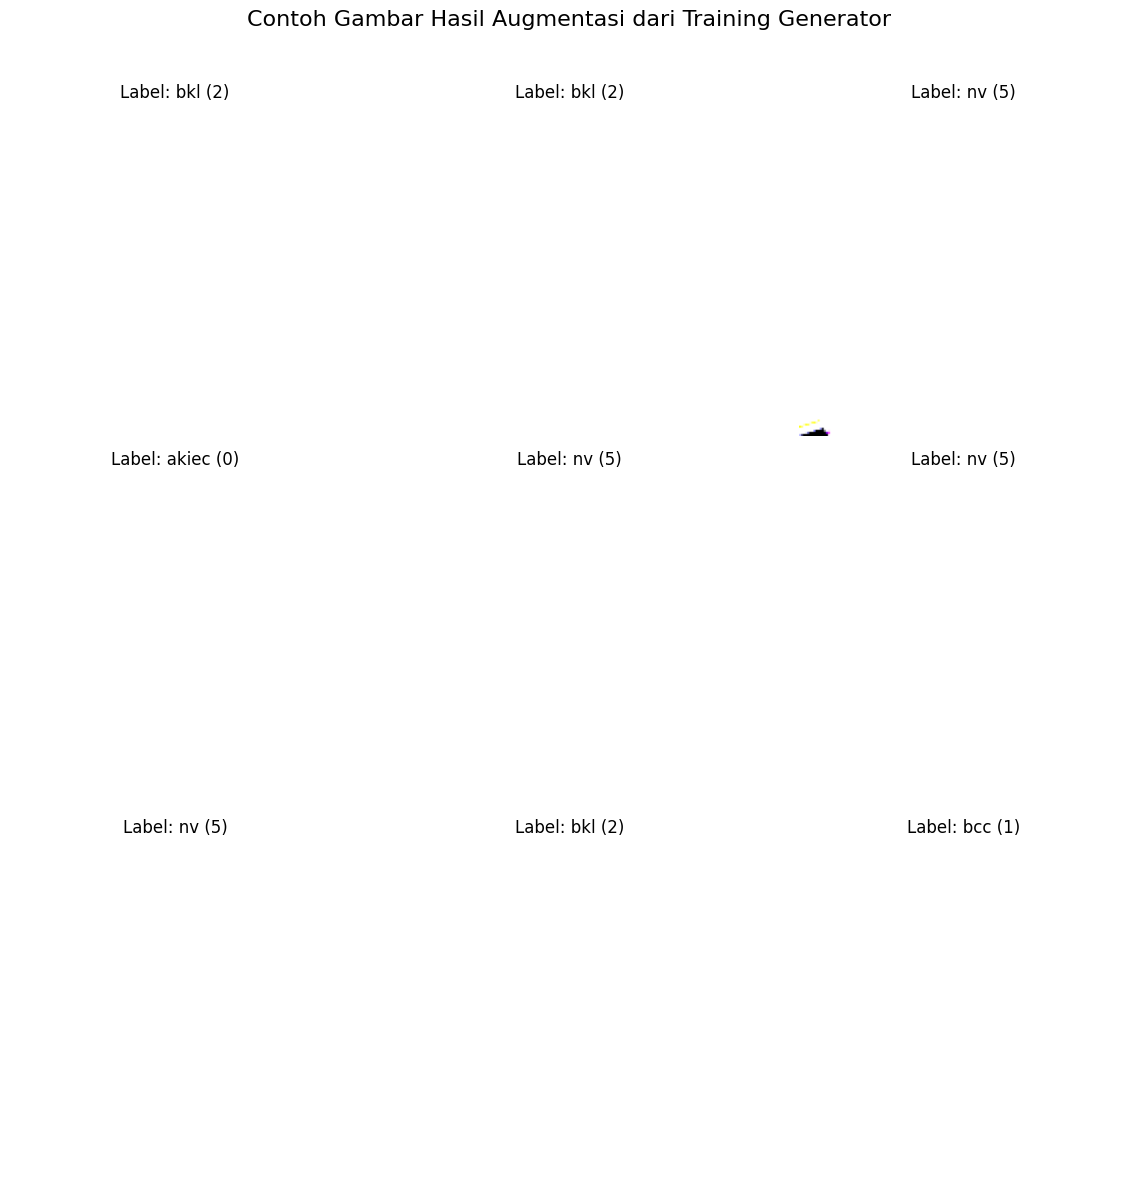

Plot contoh gambar augmentasi disimpan sebagai augmented_samples.png

--- Selesai: Image Loading, Resizing, Normalisasi, dan Augmentasi ---
Variabel yang bisa digunakan di tahap selanjutnya:
train_generator, validation_generator, test_generator
IMAGE_SIZE = (160, 160), BATCH_SIZE = 32
num_classes = 7


In [ ]:
try:
    print("\nMembuat training data generator...")
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='label', # Sekarang berisi string '0', '1', ..., '6'
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse', # Tetap sparse, karena labelnya adalah indeks kelas tunggal
        shuffle=True,
        seed=42
    )
    print("Training data generator berhasil dibuat.")

    print("\nMembuat validation data generator...")
    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )
    print("Validation data generator berhasil dibuat.")

    print("\nMembuat test data generator...")
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )
    print("Test data generator berhasil dibuat.")

    # Verifikasi output dari generator
    print("\nContoh batch dari training generator:")
    sample_batch_images, sample_batch_labels = next(train_generator)
    print(f"Bentuk batch gambar: {sample_batch_images.shape}")
    print(f"Bentuk batch label: {sample_batch_labels.shape}")
    # Karena label sekarang adalah string dari generator, kita perlu konversi ke int untuk indexing class_names
    print(f"Contoh label (raw dari generator): {sample_batch_labels[:5]}")
    print(f"Nilai min/max piksel gambar pertama di batch: {sample_batch_images[0].min()}, {sample_batch_images[0].max()}")

    # Menampilkan contoh gambar hasil augmentasi dari training generator
    plt.figure(figsize=(12, 12))
    for i in range(9):
        if i < len(sample_batch_images): # Pastikan tidak melebihi jumlah sampel di batch
            augmented_image, original_label_str = sample_batch_images[i], sample_batch_labels[i]
            original_label_int = int(float(original_label_str)) # Konversi label string ke integer
            plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_image)
            plt.title(f"Label: {class_names[original_label_int]} ({original_label_int})")
            plt.axis('off')
    plt.suptitle("Contoh Gambar Hasil Augmentasi dari Training Generator", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plot_filename = "augmented_samples.png"
    plt.savefig(plot_filename)
    plt.show()
    print(f"Plot contoh gambar augmentasi disimpan sebagai {plot_filename}")


except Exception as e:
    print(f"Error saat membuat data generator atau mengambil sampel: {e}")
    import traceback
    traceback.print_exc() # Mencetak traceback error untuk detail lebih lanjut


print("\n--- Selesai: Image Loading, Resizing, Normalisasi, dan Augmentasi ---")
print("Variabel yang bisa digunakan di tahap selanjutnya:")
print("train_generator, validation_generator, test_generator")
print(f"IMAGE_SIZE = {IMAGE_SIZE}, BATCH_SIZE = {BATCH_SIZE}")
print(f"num_classes = {num_classes}")


# **4. Membangun Model CNN**

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

# Load MobileNetV3Large tanpa top layer
base_model = MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True  # Freeze base model

# Buat model baru di atas base
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs, name="MobileNetV3_SkinCancer")

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "MobileNetV3_SkinCancer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 5, 5, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,244,167 (12.38 MB)

 Trainable params: 3,219,767 (12.28 MB)

 Non-trainable params: 24,400 (95.31 KB)

## **4.2 Melatih Model CNN**

### **4.2.1 Menghitung Class Weights**

In [ ]:
# Label di train_df masih berupa string ('0', '1', ..., '6') setelah modifikasi untuk ImageDataGenerator
try:
    # Pastikan kolom 'label' di train_df adalah tipe yang benar untuk konversi
    if train_df['label'].dtype == 'object' or train_df['label'].dtype == 'str':
        train_labels_for_weights = train_df['label'].astype(int).values
    else:
        # Jika sudah integer (misalnya jika user menjalankan ulang sel dengan modifikasi lain)
        train_labels_for_weights = train_df['label'].values

    class_weights_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels_for_weights),
        y=train_labels_for_weights
    )
    # class_weight.compute_class_weight mengembalikan array, kita butuh dictionary
    class_weights_dict = {i : class_weights_array[i] for i in range(len(class_weights_array))}

    print("Class weights yang akan digunakan:")
    for i in range(num_classes):
        print(f"Kelas {class_names[i]} (label {i}): Bobot = {class_weights_dict.get(i, 1.0):.2f}")

except Exception as e:
    print(f"Error saat menghitung class weights: {e}")
    print("Menggunakan bobot default (semua kelas bobotnya 1.0). Ini tidak ideal untuk data imbalanced.")
    class_weights_dict = None # atau {i: 1.0 for i in range(num_classes)}

Class weights yang akan digunakan:
Kelas akiec (label 0): Bobot = 4.37
Kelas bcc (label 1): Bobot = 2.78
Kelas bkl (label 2): Bobot = 1.30
Kelas df (label 3): Bobot = 12.36
Kelas mel (label 4): Bobot = 1.29
Kelas nv (label 5): Bobot = 0.21
Kelas vasc (label 6): Bobot = 10.12


### **4.2.2 Menyiapkan Callbacks**

In [ ]:
# ModelCheckpoint: Menyimpan model terbaik berdasarkan val_accuracy
checkpoint_filepath = 'best_skinalyze_model.keras' # Menggunakan format .keras modern
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Simpan seluruh model, bukan hanya weights
    monitor='val_accuracy',   # Metrik yang dipantau
    mode='max',               # Kita ingin memaksimalkan val_accuracy
    save_best_only=True,      # Hanya simpan jika lebih baik dari sebelumnya
    verbose=1
)

# EarlyStopping: Menghentikan training jika tidak ada peningkatan signifikan
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',       # Metrik yang dipantau (val_loss lebih stabil untuk early stopping)
    patience=10,              # Jumlah epoch tanpa peningkatan sebelum berhenti (misal 10)
    verbose=1,
    restore_best_weights=True # Kembalikan bobot dari epoch terbaik saat berhenti
)

# ReduceLROnPlateau: Mengurangi learning rate jika tidak ada peningkatan
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,             # Faktor pengurangan learning rate (new_lr = lr * factor)
    patience=5,             # Jumlah epoch tanpa peningkatan sebelum LR dikurangi
    min_lr=0.00001,         # Batas bawah learning rate
    verbose=1
)

callbacks_list = [model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]


### **4.2.3 Melatih Model**

In [ ]:
EPOCHS = 50 # Jumlah epoch maksimal, EarlyStopping mungkin menghentikan lebih awal

print(f"\nMemulai training model untuk maksimal {EPOCHS} epochs...")
print(f"Training data steps per epoch: {train_generator.samples // train_generator.batch_size}")
print(f"Validation data steps per epoch: {validation_generator.samples // validation_generator.batch_size}")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks_list,
    class_weight=class_weights_dict, # Menggunakan class weights yang sudah dihitung
    verbose=1
)

print("\n--- Selesai: Pelatihan Model CNN ---")




Memulai training model untuk maksimal 50 epochs...
Training data steps per epoch: 219
Validation data steps per epoch: 46


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.4319 - loss: 1.6931
Epoch 1: val_accuracy improved from -inf to 0.51731, saving model to best_skin_cancer_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 180s 566ms/step - accuracy: 0.4323 - loss: 1.6914 - val_accuracy: 0.5173 - val_loss: 2.6561 - learning_rate: 5.0000e-04
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.6113 - loss: 0.9324
Epoch 2: val_accuracy improved from 0.51731 to 0.58722, saving model to best_skin_cancer_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 92s 416ms/step - accuracy: 0.6113 - loss: 0.9324 - val_accuracy: 0.5872 - val_loss: 2.5705 - learning_rate: 5.0000e-04
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.6711 - loss: 0.6871
Epoch 3: val_accuracy improved from 0.58722 to 0.68375, saving model to best_skin_cancer_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 142s 415ms/step - accuracy: 0.6711 - loss: 0.6871 - val_accuracy: 0.6838 - val_loss: 1.5006 - learning_rate: 5

# **5. Visualisasi Hasil Training (Loss dan Accuracy)**

## **5.2 plot evaluasi train dan val**

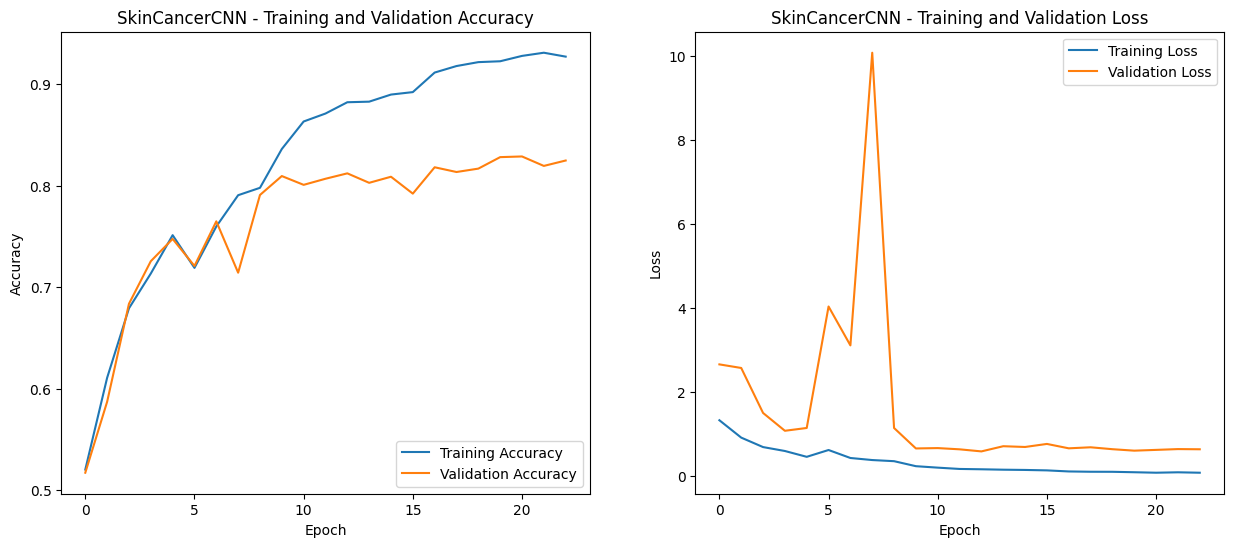

Plot histori training disimpan sebagai skincancercnn_training_history.png

Model terbaik disimpan di: best_skin_cancer_model.keras
Anda bisa memuat model terbaik ini nanti menggunakan: tf.keras.models.load_model(checkpoint_filepath)


In [ ]:
def plot_training_history(history_obj, model_name="Model"):
    acc = history_obj.history['accuracy']
    val_acc = history_obj.history['val_accuracy']
    loss = history_obj.history['loss']
    val_loss = history_obj.history['val_loss']
    epochs_range = range(len(acc)) # Jumlah epoch yang sebenarnya berjalan

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Simpan plot
    plot_filename = f"{model_name.lower().replace(' ', '_')}_training_history.png"
    plt.savefig(plot_filename)
    plt.show()
    print(f"Plot histori training disimpan sebagai {plot_filename}")

plot_training_history(history, model_name="SkinCancerCNN")

print("\nModel terbaik disimpan di:", checkpoint_filepath)
print("Anda bisa memuat model terbaik ini nanti menggunakan: tf.keras.models.load_model(checkpoint_filepath)")


## 5.2 Evaluasi pada Test Generator

In [ ]:
# 6.1 Memuat Model Terbaik
try:
    print(f"Memuat model terbaik dari: {checkpoint_filepath}")
    best_model = tf.keras.models.load_model(checkpoint_filepath)
    print("Model berhasil dimuat.")
    best_model.summary() # Tampilkan summary untuk verifikasi
except Exception as e:
    print(f"Error saat memuat model: {e}")
    print("Pastikan file model (.keras) ada di path yang benar dan training sebelumnya berhasil menyimpannya.")
    # Hentikan jika model tidak bisa dimuat
    raise SystemExit("Tidak dapat melanjutkan evaluasi tanpa model.")

Memuat model terbaik dari: best_skin_cancer_model.keras
Model berhasil dimuat.


Model: "MobileNetV3_SkinCancer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 5, 5, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,683,703 (36.94 MB)

 Trainable params: 3,219,767 (12.28 MB)

 Non-trainable params: 24,400 (95.31 KB)

 Optimizer params: 6,439,536 (24.56 MB)

In [ ]:
print("\nMelakukan evaluasi pada data test...")
results = best_model.evaluate(test_generator, verbose=1)

print("\nHasil Evaluasi pada Data Test:")
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f} ({(results[1]*100):.2f}%)")


Melakukan evaluasi pada data test...
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step - accuracy: 0.8267 - loss: 0.6555

Hasil Evaluasi pada Data Test:
Test Loss: 0.6420
Test Accuracy: 0.8303 (83.03%)


## **5.3 Prediksi pada Data Test untuk Metrik Lebih Detail**

In [ ]:
print("\nMembuat prediksi pada data test untuk laporan klasifikasi dan confusion matrix...")
# test_generator perlu di-reset sebelum prediksi jika sudah pernah diiterasi penuh
test_generator.reset()
predictions_probabilities = best_model.predict(test_generator, verbose=1)
predicted_classes_indices = np.argmax(predictions_probabilities, axis=1)
true_classes_indices = test_generator.classes

if len(predicted_classes_indices) != len(true_classes_indices):
    print(f"Peringatan: Jumlah prediksi ({len(predicted_classes_indices)}) tidak sama dengan jumlah label asli di generator ({len(true_classes_indices)}).")
    print("Ini bisa terjadi jika test_generator.samples tidak habis dibagi batch_size.")
    print("Mengambil label asli sejumlah prediksi...")
    # Ini hanya aman jika test_generator.shuffle=False (sudah kita set sebelumnya)
    num_samples_to_evaluate = len(predicted_classes_indices)
    true_classes_indices = true_classes_indices[:num_samples_to_evaluate]



Membuat prediksi pada data test untuk laporan klasifikasi dan confusion matrix...
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 295ms/step


## **5.4 Laporan Klasifikasi (Precision, Recall, F1-score)**


Laporan Klasifikasi (Data Test):
              precision    recall  f1-score   support

       akiec     0.9565    0.4490    0.6111        49
         bcc     0.8667    0.6753    0.7591        77
         bkl     0.5745    0.8182    0.6750       165
          df     0.7500    0.7059    0.7273        17
         mel     0.5634    0.7186    0.6316       167
          nv     0.9527    0.8807    0.9153      1006
        vasc     0.8077    0.9545    0.8750        22

    accuracy                         0.8303      1503
   macro avg     0.7816    0.7432    0.7421      1503
weighted avg     0.8592    0.8303    0.8368      1503


Confusion Matrix (Data Test):


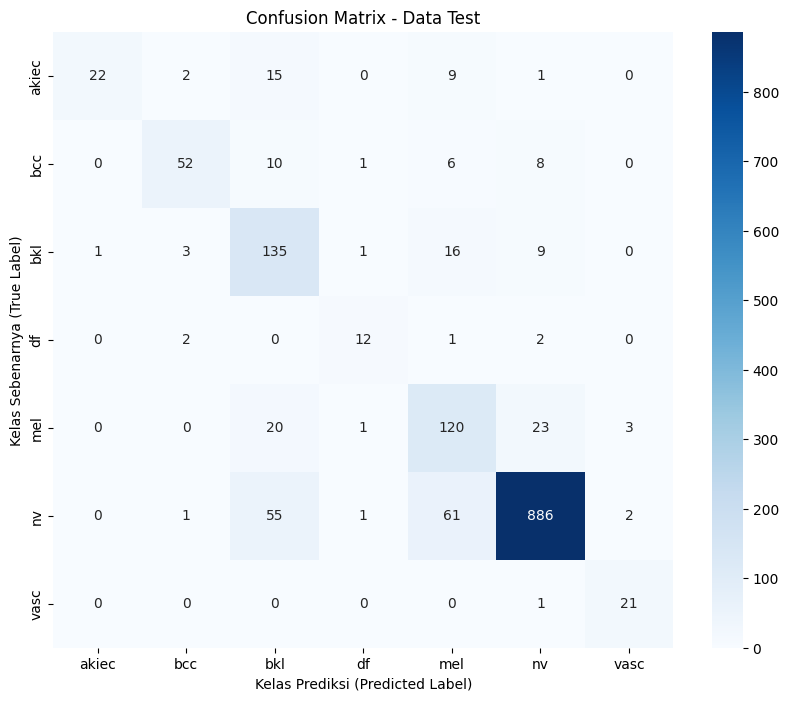

Plot confusion matrix disimpan sebagai confusion_matrix_test.png

--- Selesai: Evaluasi Model ---
Perhatikan metrik per kelas, terutama untuk 'mel' (Melanoma).


In [ ]:
print("\nLaporan Klasifikasi (Data Test):")
target_names_for_report = [str(cn) for cn in class_names]

try:
    print(classification_report(true_classes_indices, predicted_classes_indices, target_names=target_names_for_report, digits=4))
except ValueError as ve:
    print(f"Error saat membuat laporan klasifikasi: {ve}")
    print("Ini bisa terjadi jika ada ketidaksesuaian antara label yang diprediksi dan label sebenarnya, atau target_names.")
    print("Label unik sebenarnya:", np.unique(true_classes_indices))
    print("Label unik prediksi:", np.unique(predicted_classes_indices))


# Confusion Matrix
print("\nConfusion Matrix (Data Test):")
cm = confusion_matrix(true_classes_indices, predicted_classes_indices)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_for_report, yticklabels=target_names_for_report)
plt.title('Confusion Matrix - Data Test')
plt.ylabel('Kelas Sebenarnya (True Label)')
plt.xlabel('Kelas Prediksi (Predicted Label)')
# Simpan plot
cm_plot_filename = "confusion_matrix_test.png"
plt.savefig(cm_plot_filename)
plt.show()
print(f"Plot confusion matrix disimpan sebagai {cm_plot_filename}")

print("\n--- Selesai: Evaluasi Model ---")
print("Perhatikan metrik per kelas, terutama untuk 'mel' (Melanoma).")

# **6. Inferensi Model pada Satu Gambar**

Menggunakan model yang sudah ada di memori.

===== Mencoba inferensi untuk kelas: mel =====
Melakukan inferensi pada gambar contoh: ./dataset/ham10000_images_part_2/ISIC_0033444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


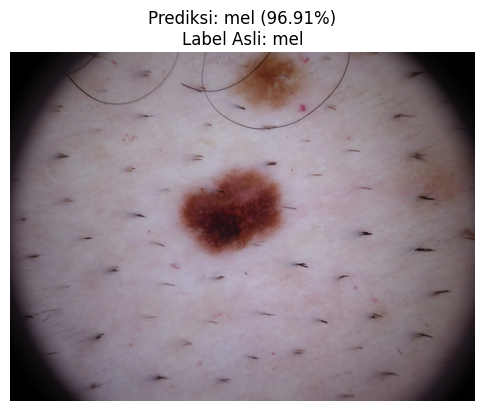

Plot hasil inferensi disimpan sebagai inference_ISIC_0033444.png

Detail Probabilitas Prediksi untuk ISIC_0033444.jpg:
- akiec: 0.00%
- bcc: 0.00%
- bkl: 0.02%
- df: 0.00%
- mel: 96.91%
- nv: 3.07%
- vasc: 0.00%

Ringkasan Inferensi:
Gambar: ISIC_0033444.jpg
Label Asli: mel
Hasil Deteksi: mel dengan keyakinan 96.91%

===== Mencoba inferensi untuk kelas: nv =====
Melakukan inferensi pada gambar contoh: ./dataset/ham10000_images_part_1/ISIC_0024368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


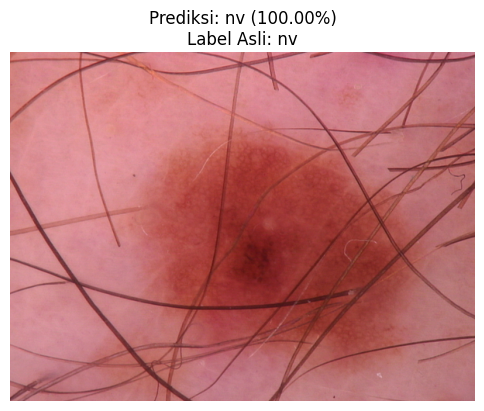

Plot hasil inferensi disimpan sebagai inference_ISIC_0024368.png

Detail Probabilitas Prediksi untuk ISIC_0024368.jpg:
- akiec: 0.00%
- bcc: 0.00%
- bkl: 0.00%
- df: 0.00%
- mel: 0.00%
- nv: 100.00%
- vasc: 0.00%

Ringkasan Inferensi:
Gambar: ISIC_0024368.jpg
Label Asli: nv
Hasil Deteksi: nv dengan keyakinan 100.00%

===== Mencoba inferensi untuk kelas: bcc =====
Melakukan inferensi pada gambar contoh: ./dataset/ham10000_images_part_1/ISIC_0028035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


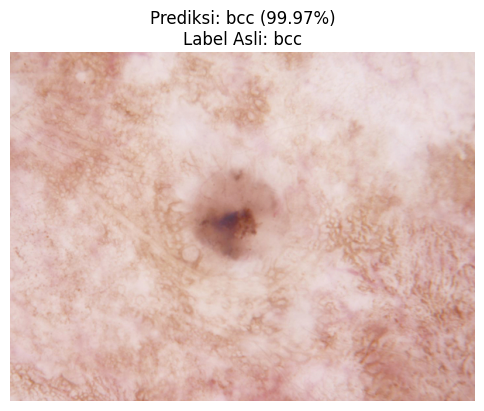

Plot hasil inferensi disimpan sebagai inference_ISIC_0028035.png

Detail Probabilitas Prediksi untuk ISIC_0028035.jpg:
- akiec: 0.00%
- bcc: 99.97%
- bkl: 0.01%
- df: 0.00%
- mel: 0.01%
- nv: 0.02%
- vasc: 0.00%

Ringkasan Inferensi:
Gambar: ISIC_0028035.jpg
Label Asli: bcc
Hasil Deteksi: bcc dengan keyakinan 99.97%

===== Mencoba inferensi untuk kelas: df =====
Melakukan inferensi pada gambar contoh: ./dataset/ham10000_images_part_1/ISIC_0027118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


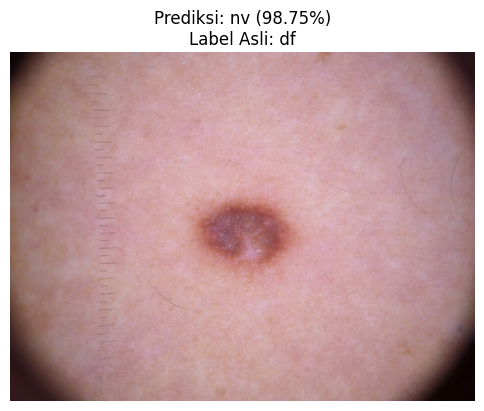

Plot hasil inferensi disimpan sebagai inference_ISIC_0027118.png

Detail Probabilitas Prediksi untuk ISIC_0027118.jpg:
- akiec: 0.00%
- bcc: 0.00%
- bkl: 0.02%
- df: 0.03%
- mel: 1.20%
- nv: 98.75%
- vasc: 0.00%

Ringkasan Inferensi:
Gambar: ISIC_0027118.jpg
Label Asli: df
Hasil Deteksi: nv dengan keyakinan 98.75%

===== Mencoba inferensi untuk kelas: akiec =====
Melakukan inferensi pada gambar contoh: ./dataset/ham10000_images_part_1/ISIC_0028370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


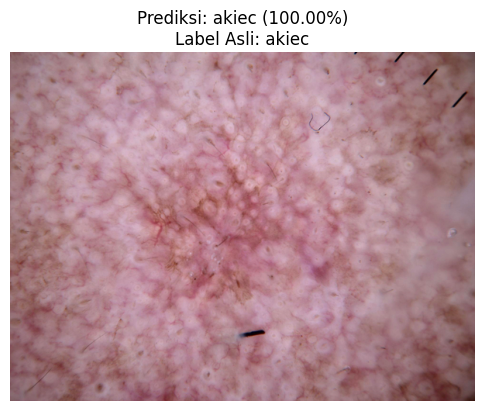

Plot hasil inferensi disimpan sebagai inference_ISIC_0028370.png

Detail Probabilitas Prediksi untuk ISIC_0028370.jpg:
- akiec: 100.00%
- bcc: 0.00%
- bkl: 0.00%
- df: 0.00%
- mel: 0.00%
- nv: 0.00%
- vasc: 0.00%

Ringkasan Inferensi:
Gambar: ISIC_0028370.jpg
Label Asli: akiec
Hasil Deteksi: akiec dengan keyakinan 100.00%

===== Mencoba inferensi untuk kelas: bkl =====
Melakukan inferensi pada gambar contoh: ./dataset/ham10000_images_part_2/ISIC_0031987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


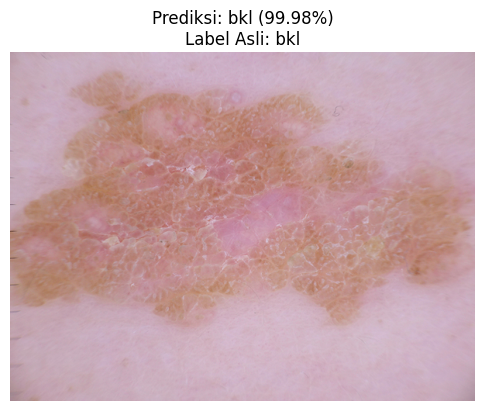

Plot hasil inferensi disimpan sebagai inference_ISIC_0031987.png

Detail Probabilitas Prediksi untuk ISIC_0031987.jpg:
- akiec: 0.00%
- bcc: 0.00%
- bkl: 99.98%
- df: 0.00%
- mel: 0.00%
- nv: 0.01%
- vasc: 0.00%

Ringkasan Inferensi:
Gambar: ISIC_0031987.jpg
Label Asli: bkl
Hasil Deteksi: bkl dengan keyakinan 99.98%

===== Mencoba inferensi untuk kelas: vasc =====
Melakukan inferensi pada gambar contoh: ./dataset/ham10000_images_part_2/ISIC_0031346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


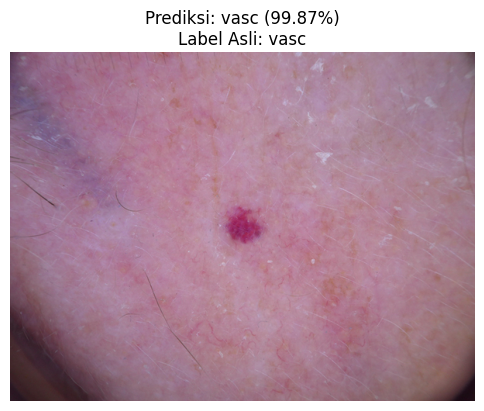

Plot hasil inferensi disimpan sebagai inference_ISIC_0031346.png

Detail Probabilitas Prediksi untuk ISIC_0031346.jpg:
- akiec: 0.00%
- bcc: 0.00%
- bkl: 0.00%
- df: 0.00%
- mel: 0.10%
- nv: 0.03%
- vasc: 99.87%

Ringkasan Inferensi:
Gambar: ISIC_0031346.jpg
Label Asli: vasc
Hasil Deteksi: vasc dengan keyakinan 99.87%


In [ ]:
# class_names (daftar nama kelas ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc'])
# IMAGE_SIZE (misal (128, 128))
# test_df (DataFrame berisi 'path' dan 'label' untuk data test)

def preprocess_single_image(img_path, target_size):
    """Memuat dan melakukan preprocessing pada satu gambar."""
    img = keras_image_processing.load_img(img_path, target_size=target_size)
    img_array = keras_image_processing.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Membuat batch berisi 1 gambar
    img_array = mobilenet_preprocess(img_array) # Normalisasi, sama seperti saat training
    return img_array

def predict_and_display(model, img_path, target_size, class_names_list, test_df_ref):
    """Melakukan prediksi pada satu gambar dan menampilkan hasilnya."""
    processed_img = preprocess_single_image(img_path, target_size)
    predictions_proba = model.predict(processed_img)
    predicted_class_index = np.argmax(predictions_proba, axis=1)[0]
    predicted_class_name = class_names_list[predicted_class_index]
    confidence = predictions_proba[0][predicted_class_index] * 100

    plt.figure(figsize=(6, 7))
    img_display = keras_image_processing.load_img(img_path)
    plt.imshow(img_display)

    title_text = f"Prediksi: {predicted_class_name} ({confidence:.2f}%)\n"
    original_class_name_str = "Tidak diketahui"
    original_label_row = test_df_ref[test_df_ref['path'] == img_path]
    if not original_label_row.empty:
        # Pastikan class_names_list adalah list untuk menggunakan .index()
        class_names_as_list_for_label = class_names_list.tolist() if isinstance(class_names_list, np.ndarray) else list(class_names_list)
        original_label_index = int(original_label_row['label'].iloc[0])
        original_class_name_str = class_names_as_list_for_label[original_label_index]
        title_text += f"Label Asli: {original_class_name_str}"
    else:
        title_text += "Label Asli: Tidak diketahui (path tidak ada di test_df)"

    plt.title(title_text)
    plt.axis('off')
    plot_filename = f"inference_{os.path.basename(img_path).split('.')[0]}.png"
    plt.savefig(plot_filename)
    plt.show()
    print(f"Plot hasil inferensi disimpan sebagai {plot_filename}")

    print(f"\nDetail Probabilitas Prediksi untuk {os.path.basename(img_path)}:")
    for i, class_name_iter in enumerate(class_names_list):
        print(f"- {class_name_iter}: {predictions_proba[0][i]*100:.2f}%")

    print(f"\nRingkasan Inferensi:")
    print(f"Gambar: {os.path.basename(img_path)}")
    print(f"Label Asli: {original_class_name_str}")
    print(f"Hasil Deteksi: {predicted_class_name} dengan keyakinan {confidence:.2f}%")
    return predicted_class_name, confidence, original_class_name_str

def perform_inference_for_class(target_class_name, model_to_use, image_size_tuple, class_names_list_all, df_test_data):
    """Melakukan inferensi untuk sampel acak dari kelas target yang ditentukan."""
    # Konversi class_names_list_all ke list Python jika berupa numpy array
    if isinstance(class_names_list_all, np.ndarray):
        class_names_as_list = class_names_list_all.tolist()
    else:
        class_names_as_list = list(class_names_list_all) # Pastikan ini adalah list

    if target_class_name not in class_names_as_list:
        print(f"Nama kelas '{target_class_name}' tidak valid. Pilih dari: {class_names_as_list}")
        return

    print(f"\n===== Mencoba inferensi untuk kelas: {target_class_name} =====")
    # Dapatkan indeks dari nama kelas target
    target_label_index = class_names_as_list.index(target_class_name)
    target_label_str = str(target_label_index) # Label di df_test_data adalah string '0', '1', ...

    target_images_df = df_test_data[df_test_data['label'] == target_label_str]

    if not target_images_df.empty:
        sample_path = random.choice(target_images_df['path'].tolist())
        print(f"Melakukan inferensi pada gambar contoh: {sample_path}")
        # Saat memanggil predict_and_display, pastikan class_names_list_all yang dikirim adalah yang asli (bisa numpy array atau list)
        # karena predict_and_display akan menangani konversinya sendiri jika perlu untuk label asli.
        predict_and_display(model_to_use, sample_path, image_size_tuple, class_names_list_all, df_test_data)
    else:
        print(f"Tidak ditemukan gambar dengan label '{target_class_name}' di test_df untuk contoh inferensi.")

# --- Contoh Penggunaan Inferensi untuk Kelas Tertentu ---
# Muat model jika belum ada di memori
checkpoint_filepath = 'best_skinalyze_model.keras'
try:
    # Cek apakah best_model sudah ada dan merupakan model Keras
    if 'best_model' not in locals() or not isinstance(best_model, tf.keras.Model):
        print(f"Memuat ulang model dari {checkpoint_filepath}...")
        best_model = tf.keras.models.load_model(checkpoint_filepath)
        print("Model berhasil dimuat ulang untuk inferensi.")
    else:
        print("Menggunakan model yang sudah ada di memori.")
except Exception as e:
    print(f"Gagal memuat model: {e}")
    raise SystemExit("Tidak dapat melanjutkan inferensi tanpa model.")


# inferensi untuk kelas 'mel'
perform_inference_for_class('mel', best_model, IMAGE_SIZE, class_names, test_df)

# inferensi untuk kelas 'nv'
perform_inference_for_class('nv', best_model, IMAGE_SIZE, class_names, test_df)

# inferensi untuk kelas 'bcc'
perform_inference_for_class('bcc', best_model, IMAGE_SIZE, class_names, test_df)

# inferensi untuk kelas 'df'
perform_inference_for_class('df', best_model, IMAGE_SIZE, class_names, test_df)

# inferensi untuk kelas 'akiec'
perform_inference_for_class('akiec', best_model, IMAGE_SIZE, class_names, test_df)

# inferensi untuk kelas 'bkl'
perform_inference_for_class('bkl', best_model, IMAGE_SIZE, class_names, test_df)

# inferensi untuk kelas'vasc'
perform_inference_for_class('vasc', best_model, IMAGE_SIZE, class_names, test_df)

# **7. Ekspor Model**

**Ekspor model  H5**

In [ ]:
if 'best_model' not in locals() or not isinstance(best_model, tf.keras.Model):
    print(f"Memuat ulang model terbaik dari: {checkpoint_filepath}")
    try:
        best_model = tf.keras.models.load_model(checkpoint_filepath)
        print("Model berhasil dimuat ulang.")
    except Exception as e:
        print(f"Error saat memuat model: {e}")
        raise SystemExit("Tidak dapat melanjutkan ekspor tanpa model.")
else:
    print("Menggunakan model yang sudah ada di memori ('best_model').")

# Direktori untuk menyimpan model yang diekspor
export_dir = 'exported_models'
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
print(f"Model akan diekspor ke direktori: {export_dir}")

# Ekspor ke format Keras H5 (.h5)
h5_model_path = os.path.join(export_dir, 'skinalyze_model.h5')
try:
    best_model.save(h5_model_path)
    print(f"\nModel berhasil disimpan dalam format Keras H5 di: {h5_model_path}")
    print(f"Ukuran file H5: {os.path.getsize(h5_model_path)/1024/1024:.2f} MB")
except Exception as e:
    print(f"Error saat menyimpan ke format H5: {e}")

Menggunakan model yang sudah ada di memori ('best_model').
Model akan diekspor ke direktori: exported_models

Model berhasil disimpan dalam format Keras H5 di: exported_models/skin_cancer_model.h5
Ukuran file H5: 37.50 MB


In [ ]:
# 2. Ekspor ke format TensorFlow Lite (.tflite)
tflite_model_path = os.path.join(export_dir, 'skinalyze_model.tflite')
try:
    # Konversi model ke TFLite (tanpa kuantisasi awal untuk kesederhanaan)
    converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
    tflite_model = converter.convert()

    # Simpan model TFLite
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    print(f"\nModel berhasil dikonversi dan disimpan dalam format TensorFlow Lite di: {tflite_model_path}")
    print(f"Ukuran file TFLite: {os.path.getsize(tflite_model_path)/1024/1024:.2f} MB")
except Exception as e:
    print(f"Error saat mengonversi ke TFLite: {e}")
    print("Jika menggunakan kuantisasi integer, pastikan 'representative_data_gen' dan 'IMAGE_SIZE' sudah benar.")

**3. Ekspor ke format TensorFlow.js**

In [ ]:
# 3. Ekspor ke format TensorFlow.js
print("\n--- Selesai: Proses Ekspor Model ---")
print(f"Semua model yang berhasil diekspor ada di direktori '{export_dir}'.")
print("Anda mungkin perlu mengunduh direktori atau file ini dari lingkungan Colab Anda.")

In [ ]:
!pip install tensorflowjs

In [ ]:
# !pip install tensorflowjs
import tensorflowjs as tfjs # Import setelah potensi instalasi

tfjs_model_path = os.path.join(export_dir, 'skinalyze_model_tfjs')
try:
    # Perintah konversi: tensorflowjs.converters.save_keras_model(model, output_path)
    tfjs.converters.save_keras_model(best_model, tfjs_model_path)
    print(f"\nModel berhasil dikonversi dan disimpan dalam format TensorFlow.js di direktori: {tfjs_model_path}")
    # Ukuran file untuk TF.js biasanya adalah total ukuran direktori
    total_size_tfjs = 0
    for dirpath, dirnames, filenames in os.walk(tfjs_model_path):
        for f_tfjs in filenames:
            fp = os.path.join(dirpath, f_tfjs)
            total_size_tfjs += os.path.getsize(fp)
    print(f"Total ukuran direktori TF.js: {total_size_tfjs/1024/1024:.2f} MB")
    print(f"File utama: {os.path.join(tfjs_model_path, 'model.json')}")
except ImportError:
    print("\nError: Paket 'tensorflowjs' tidak ditemukan. Silakan instal terlebih dahulu.")
    print("Anda bisa menjalankannya di sel baru: !pip install tensorflowjs")
    print("Kemudian jalankan ulang bagian ekspor TensorFlow.js dari kode ini.")
except Exception as e:
    print(f"Error saat mengonversi ke TensorFlow.js: {e}")


In [ ]:
import shutil
from google.colab import files

shutil.make_archive('exported_models', 'zip', '/content/exported_models')
files.download('exported_models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>